<a href="https://colab.research.google.com/github/Hasim-dev/Brain-Tumor-Diagnosis/blob/master/Brain_Tumor_GoogleNet_aug_var_t_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from PIL import Image
import cv2
import time

In [3]:
from google.colab import files
uploaded = files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasimdev/bitirme-dataset-tv # api copied from kaggle
import os
os.listdir('/content/')
import zipfile
with zipfile.ZipFile('/content/bitirme-dataset-tv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/bitirme_dataset_train_val')

Saving kaggle.json to kaggle.json
 65% 33.0M/50.6M [00:00<00:00, 67.4MB/s]
100% 50.6M/50.6M [00:00<00:00, 128MB/s] 


In [4]:
!ls

bitirme_dataset_train_val  bitirme-dataset-tv.zip  kaggle.json	sample_data


In [5]:
!ls /content/bitirme_dataset_train_val

bitirme_dataset_train  bitirme_dataset_val


In [0]:
transform_train = transforms.Compose([transforms.Resize((96,96)),
                                      transforms.Resize((299, 299)), # boyut 299x299 yapıldı
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=20, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean ve std
                               ])

transform = transforms.Compose([transforms.Resize((299, 299)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean ve std
                               ]) # transform'u oluşturduk. ToTensor ve Normalize ile tensora dönüştürdük ve normalize ettik

# /data içine data'yı koy, train_set oluştur, indir, transform'u koy
training_dataset = datasets.ImageFolder('/content/bitirme_dataset_train_val/bitirme_dataset_train', transform=transform_train)
validation_dataset = datasets.ImageFolder('/content/bitirme_dataset_train_val/bitirme_dataset_val', transform=transform)

# epoch için tek seferde 60.000 image fazla olur. "batch_size" ile bölüyoruz. "shuffle" global minimum içindi.
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=False)

In [8]:
print(len(training_dataset), len(validation_dataset)) # elimizdeki mr sayısına bakalım.

1583 395


In [0]:
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.clone().detach().numpy() 
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]) # get the image back
  
  #Mormalizing the image mader our image -1 to 1. To ensure that the image is 0 to 1.
  image = image.clip(0, 1)
  
  return image

In [0]:
classes = ("healthy", "unhealthy")

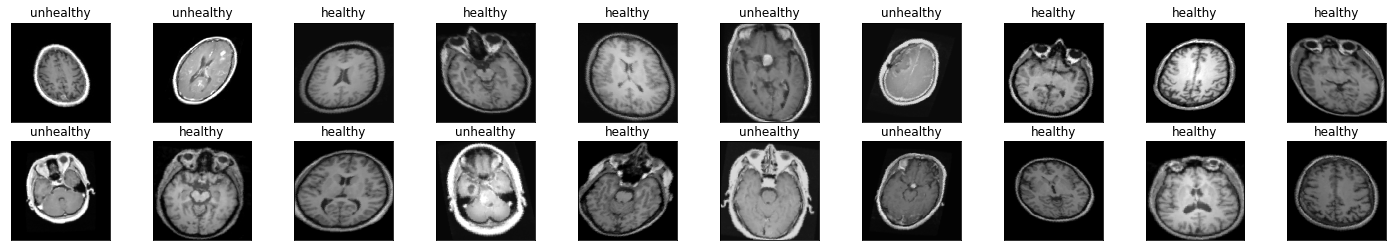

In [11]:
dataiter = iter(training_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title(classes[labels[idx].item()]) #her image için title

In [12]:
model = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 47.5MB/s]


In [0]:
%%capture
print(model)

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
 # Conv layerların değişmesini engelledik. Sadece FC layerlar değişiyor.

In [0]:
# Netin sonunda classifier 1000 outputa sahip. Bize 2 output gerekiyor.
%%capture
import torch.nn as nn

model.aux_logits = False
model.fc = nn.Linear(2048, len(classes))

print(model)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [18]:
epochs = 5
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  start_time=time.time()
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    #inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels) # output ve labellar karşılaştırılıyor.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # gelen outputlardan max değerli olanı alıyoruz.
    # ilk değer max score, ikinci değer max score'un index değerini döndürüyor.
    _, preds = torch.max(outputs, 1) 
    running_loss += loss.item()
    # single batch of images'da doğru prediction sayısını veriyor.
    running_corrects += torch.sum(preds == labels.data) 
        
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.to(device)
        #val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1) 
        val_running_loss += val_loss.item()
        # single batch of images'da doğru prediction sayısını veriyor.
        val_running_corrects += torch.sum(val_preds == val_labels.data) 
    
    
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss) #epoch_loss, listeye eklendi.
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch', (e+1))
    print('Training Loss: {:.4f}, acc {:.4f}' .format(epoch_loss, epoch_acc.item()))
    print('Validation Loss: {:.4f}, acc {:.4f}' .format(val_epoch_loss, val_epoch_acc.item()))
    print("\n--- %s seconds ---" % (time.time() - start_time))    

epoch 1
Training Loss: 0.0070, acc 0.4921
Validation Loss: 0.0065, acc 0.6835

--- 812.7096359729767 seconds ---
epoch 2
Training Loss: 0.0059, acc 0.5818
Validation Loss: 0.0075, acc 0.5873

--- 822.9280817508698 seconds ---
epoch 3
Training Loss: 0.0052, acc 0.6323
Validation Loss: 0.0102, acc 0.6430

--- 826.0592675209045 seconds ---
epoch 4
Training Loss: 0.0041, acc 0.7549
Validation Loss: 0.0110, acc 0.7392

--- 814.6321012973785 seconds ---
epoch 5
Training Loss: 0.0021, acc 0.9059
Validation Loss: 0.0139, acc 0.6810

--- 811.3785011768341 seconds ---


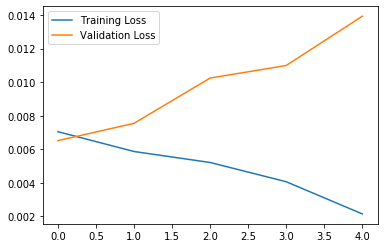

In [19]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()
plt.show()

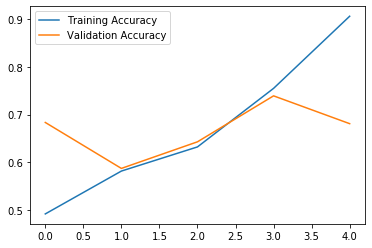

In [20]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()
plt.show()

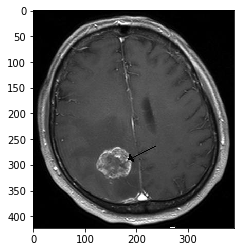

In [21]:
import requests
import PIL.ImageOps
from PIL import Image
url1 = 'https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly91cGxvYWQud2lraW1lZGlhLm9yZy93aWtpcGVkaWEvY29tbW9ucy81LzVmL0hpcm5tZXRhc3Rhc2VfTVJULVQxX0tNLmpwZw'
response = requests.get(url1, stream = True)
img1 = Image.open(response.raw)
plt.imshow(img1)

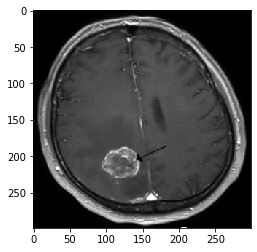

In [22]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [23]:
img1 = img1.unsqueeze(0)
output = model(img1)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

unhealthy


unhealthy


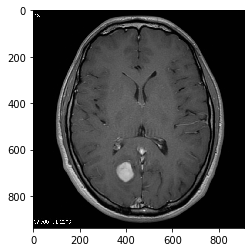

In [24]:
url2 = 'https://prod-images.static.radiopaedia.org/images/5651/b510dc0d5cd3906018c4dd49b98643.jpg'
response = requests.get(url2, stream = True)
img2 = Image.open(response.raw)
plt.imshow(img2)
img2 = transform(img2)
img2 = img2.unsqueeze(0)
output = model(img2)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

In [0]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=40, shuffle=False)

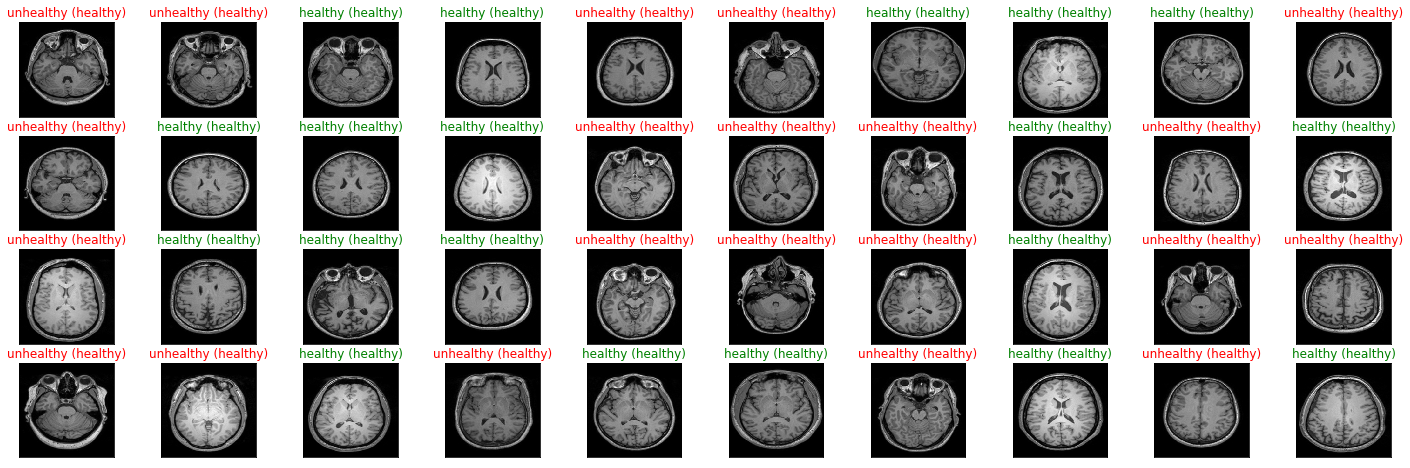

In [44]:
dataiter = iter(validation_loader) # validation loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
images = images#.to(device)
labels = labels#.to(device)
output = model(images)
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25, 8))

for idx in np.arange(40):
  ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red")) #her image için title

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [0]:
#modeli kaydet
torch.save(model.state_dict(), 'vgg_9051.pth')

In [0]:
vgg_model_son = 'vgg_model_son.pth'
path = F"/content/drive/My Drive/vgg_model_son" 
torch.save(model.state_dict(), path)

In [0]:
vgg_model_son = 'vgg_model_son.pth'
path = F"/content/drive/My Drive/vgg_model_son"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1